In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xbg

In [2]:
# separate main drum components
files_snare = glob('data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike/*.wav')
files_toms_rack = glob('data/MDLib2.2/MDLib2.2/Sorted/Rack Tom/Strike/*.wav')
files_toms_floor = glob('data/MDLib2.2/MDLib2.2/Sorted/Floor Tom/Strike/*.wav')
files_kick = glob('data/MDLib2.2/MDLib2.2/Sorted/Kick/*/*/*.wav')

files_cymbals = glob('data/MDLib2.2/MDLib2.2/Sorted/Cymbals/*/*/*.wav')
files_hihat = glob('data/MDLib2.2/MDLib2.2/Sorted/Cymbals/HiHat/*/*.wav')
files_ride = glob('data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Ride/Tip/*.wav')
files_crash = glob('data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Bright Crash/*/*.wav')
files_dark_crash = glob('data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash/*/*.wav')

# combine bright and dark crash files
for i in files_dark_crash:
    files_crash.append(i)

#audio_files = glob('data/MDLib2.2/MDLib2.2/Sorted/*/*/*.wav')

In [3]:
glob('data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash/*/*.wav')

['data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash\\Clamp\\DI_Dark Crash_Clamp_1111.1.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash\\Clamp\\DI_Dark Crash_Clamp_1111.2.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash\\Clamp\\DI_Dark Crash_Clamp_1111.3.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash\\Clamp\\DI_Dark Crash_Clamp_1111.4.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash\\Clamp\\DI_Dark Crash_Clamp_1112.1.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash\\Clamp\\DI_Dark Crash_Clamp_1112.2.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash\\Clamp\\DI_Dark Crash_Clamp_1112.3.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash\\Clamp\\DI_Dark Crash_Clamp_1112.4.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash\\Clamp\\DI_Dark Crash_Clamp_1113.1.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash\\Clamp\\DI_Dark Crash_Clamp_1113.2.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Cymbals/Dark Crash\\Clamp\\DI_Dark Crash_Clamp_1

In [4]:
# def load_file_list(file_list):
#     for file in file_list:
#         y, sr = librosa.load(file)
        
#     return y, sr

In [5]:
#load_file_list(files_snare)

In [6]:
def load_file(file):
    
    y_values = []
    sample_rates = []
    
    for i in file:
        
        y, sr = librosa.load(i)
        
        y_values.append(y)
        sample_rates.append(sr)
        
        
        
    return y_values, sample_rates

In [7]:
#load_file(files_snare)

In [8]:
# duration of file
def get_duration(file):
    dur = librosa.get_duration(filename=file)
    return dur

In [9]:
def trim_audio(y, db=25):
    y_trimmed, ind = librosa.effects.trim(y, top_db=db)
    dur_trimmed = librosa.get_duration(y=y_trimmed)
    return(dur_trimmed)

In [10]:
def trim_y(y, db=25):
    y_trimmed, ind = librosa.effects.trim(y, top_db=db)
    return(y_trimmed)

### Dataframe Assembly

#### Assembly Cont.
    Snare Dataframe Assembly

In [11]:
files_snare[:5]

['data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\\DI_Snare_Strike_1111.1.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\\DI_Snare_Strike_1111.2.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\\DI_Snare_Strike_1111.3.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\\DI_Snare_Strike_1111.4.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\\DI_Snare_Strike_1112.1.wav']

In [12]:
y, sr = load_file(files_snare)

snare = pd.DataFrame({
    "file_name": files_snare,
    "ins": 'snare',
    "sr": sr,
    "y": y
})
snare['y_trimmed'] = snare['y'].map(trim_y)
snare['length'] = snare['file_name'].map(get_duration)
snare['length_trimmed'] = snare['y'].map(trim_audio)

In [13]:
snare.head()

,file_name,ins,sr,y,y_trimmed,length,length_trimmed
0,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-1.5206266e-05, -1.3785218e-05, -8.188464e-06...","[-1.5206266e-05, -1.3785218e-05, -8.188464e-06...",0.932336,0.255420
1,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-2.0711204e-05, -1.7712298e-05, -9.776115e-06...","[-2.0711204e-05, -1.7712298e-05, -9.776115e-06...",0.640068,0.278639
2,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-7.5879116e-06, 2.1694016e-06, 1.2658389e-05,...","[-7.5879116e-06, 2.1694016e-06, 1.2658389e-05,...",0.792449,0.255420
3,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[1.1276075e-05, 7.2365297e-06, 2.8594923e-06, ...","[1.1276075e-05, 7.2365297e-06, 2.8594923e-06, ...",0.705147,0.255420
4,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[3.2032644e-05, 3.0818876e-05, -5.6142153e-06,...","[3.2032644e-05, 3.0818876e-05, -5.6142153e-06,...",0.887007,0.208980


#### Preview First Snare Sound With iPython

In [14]:
ipd.Audio(snare['file_name'].iloc[0])

#### Checking Difference in Length After Trimming

In [15]:
librosa.get_duration(y=snare['y'].iloc[0], sr=22050)
#0.9323356009070295

0.9323356009070295

In [16]:
x, ind = librosa.effects.trim(y=snare['y'].iloc[0], top_db=25)
librosa.get_duration(y=x)
#0.25541950113378686

0.25541950113378686

#### Assembly Cont.
    Remaining Dataframe Assembly

In [22]:
# Create RACK TOMS dataframe
y, sr = load_file(files_toms_rack)

toms_rack = pd.DataFrame({
    "file_name": files_toms_rack,
    "ins": 'rack_tom',
    "sr": sr,
    "y": y
})
# Add trimmed columns
toms_rack['y_trimmed'] = toms_rack['y'].map(trim_y)
toms_rack['length'] = toms_rack['file_name'].map(get_duration)
toms_rack['length_trimmed'] = toms_rack['y'].map(trim_audio)



# Create FLOOR TOMS dataframe
y, sr = load_file(files_toms_floor)

toms_floor = pd.DataFrame({
    "file_name": files_toms_floor,
    "ins": 'floor_tom',
    "sr": sr,
    "y": y
})
# Add trimmed columns
toms_floor['y_trimmed'] = toms_floor['y'].map(trim_y)
toms_floor['length'] = toms_floor['file_name'].map(get_duration)
toms_floor['length_trimmed'] = toms_floor['y'].map(trim_audio)



# Create KICK dataframe
y, sr = load_file(files_kick)

kick = pd.DataFrame({
    "file_name": files_kick,
    "ins": 'kick',
    "sr": sr,
    "y": y
})
# Add trimmed columns
kick['y_trimmed'] = kick['y'].map(trim_y)
kick['length'] = kick['file_name'].map(get_duration)
kick['length_trimmed'] = kick['y'].map(trim_audio)



# Create HIHAT dataframe
y, sr = load_file(files_hihat)

hihat = pd.DataFrame({
    "file_name": files_hihat,
    "ins": 'hihat',
    "sr": sr,
    "y": y
})
# Add trimmed columns
hihat['y_trimmed'] = hihat['y'].map(trim_y)
hihat['length'] = hihat['file_name'].map(get_duration)
hihat['length_trimmed'] = hihat['y'].map(trim_audio)



# Create RIDE CYMBAL dataframe
y, sr = load_file(files_ride)

ride = pd.DataFrame({
    "file_name": files_ride,
    "ins": 'ride',
    "sr": sr,
    "y": y
})
# Add trimmed columns
ride['y_trimmed'] = ride['y'].map(trim_y)
ride['length'] = ride['file_name'].map(get_duration)
ride['length_trimmed'] = ride['y'].map(trim_audio)



# Create CRASH CYMBAL dataframe
y, sr = load_file(files_crash)

crash = pd.DataFrame({
    "file_name": files_crash,
    "ins": 'crash',
    "sr": sr,
    "y": y
})
# Add trimmed columns
crash['y_trimmed'] = crash['y'].map(trim_y)
crash['length'] = crash['file_name'].map(get_duration)
crash['length_trimmed'] = crash['y'].map(trim_audio)



# COMBINE dataframes
df_list = [snare, toms_rack, toms_floor, kick, hihat, ride, crash]

df = pd.concat(df_list)

In [23]:
df['ins'].value_counts()

hihat        1280
crash         640
snare         576
kick          480
floor_tom     384
rack_tom      384
ride          256
Name: ins, dtype: int64

## Feature Engineering

In [24]:
def get_summary_stats(y):
    
    # creates one column df to perform descriptive stats on
    col = pd.DataFrame(y).T
    
    # get descriptive stats
    ds = col.describe(include='all')
    
    # assign variables for each stat
    mean = ds.loc['mean']
    std = ds.loc['std']
    mini = ds.loc['min']
    q1 = ds.loc['25%']
    medi = ds.loc['50%']
    q3 = ds.loc['75%']
    maxi = ds.loc['max']
    
    return(mean, std, mini, q1, medi, q3, maxi)

In [25]:
def calc_rms(y):
    rms = librosa.feature.rms(y=y, frame_length=2048)
    return(rms)

In [26]:
# def calc_rms_summary(y):
#     rms = librosa.feature.rms(y=y, frame_length=2048)
    
#     results = get_summary_stats(rms)
#     return(rms, results)

In [27]:
def calc_spec_centroid(y):
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=22050)
    return(spec_cent)

In [28]:
def calc_spec_bandwidth(y):
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=22050)
    return(spec_bandwidth)

In [29]:
def calc_spec_rolloff(y):
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=22050)
    return(spec_rolloff)

In [30]:
def calc_zero_cross(y):
    zero_cross_rate = librosa.feature.zero_crossing_rate(y=y, frame_length=2048)
    return(zero_cross_rate)

#### Calculating New Features

In [31]:
df['rms'] = df['y_trimmed'].map(calc_rms)

x = [get_summary_stats(i) for i in df['rms']]

df['rms_mean'] = [i[0][0] for i in x]
df['rms_std'] = [i[1][0] for i in x]
df['rms_min'] = [i[2][0] for i in x]
df['rms_25%'] = [i[3][0] for i in x]
df['rms_median'] = [i[4][0] for i in x]
df['rms_75%'] = [i[5][0] for i in x]
df['rms_max'] = [i[6][0] for i in x]
df['rms_IQR'] = abs(df['rms_25%'] - df['rms_75%'])

filter_col = [col for col in df if col.startswith('rms')]
df[filter_col].head(2)

,rms,rms_mean,rms_std,rms_min,rms_25%,rms_median,rms_75%,rms_max,rms_IQR
0,"[[0.004205495, 0.004348958, 0.0044075986, 0.00...",0.001781,0.001661,0.000206,0.000606,0.000920,0.003062,0.004408,0.002456
1,"[[0.0032281945, 0.0033489498, 0.003410472, 0.0...",0.001321,0.001256,0.000134,0.000447,0.000693,0.002137,0.003410,0.001690


In [32]:
df['spec_centroid'] = df['y_trimmed'].map(calc_spec_centroid)

x = [get_summary_stats(i) for i in df['spec_centroid']]

df['spec_centroid_mean'] = [i[0][0] for i in x]
df['spec_centroid_std'] = [i[1][0] for i in x]
df['spec_centroid_min'] = [i[2][0] for i in x]
df['spec_centroid_25%'] = [i[3][0] for i in x]
df['spec_centroid_median'] = [i[4][0] for i in x]
df['spec_centroid_75%'] = [i[5][0] for i in x]
df['spec_centroid_max'] = [i[6][0] for i in x]
df['spec_centroid_IQR'] = abs(df['spec_centroid_25%'] - df['spec_centroid_75%'])

filter_col = [col for col in df if col.startswith('spec_cen')]
df[filter_col].head(2)

,spec_centroid,spec_centroid_mean,spec_centroid_std,spec_centroid_min,spec_centroid_25%,spec_centroid_median,spec_centroid_75%,spec_centroid_max,spec_centroid_IQR
0,"[[2200.5189792513956, 3002.457212659452, 3718....",2498.367607,763.918829,1726.453488,1810.371199,2265.433842,3063.787697,3718.931386,1253.416498
1,"[[1803.2787502736414, 2625.3336033881524, 3486...",2305.111611,700.064448,1614.252395,1681.912915,2046.480739,2625.333603,3571.054016,943.420688


In [33]:
df['spec_bandwidth'] = df['y_trimmed'].map(calc_spec_bandwidth)

x = [get_summary_stats(i) for i in df['spec_bandwidth']]

df['spec_bandwidth_mean'] = [i[0][0] for i in x]
df['spec_bandwidth_std'] = [i[1][0] for i in x]
df['spec_bandwidth_min'] = [i[2][0] for i in x]
df['spec_bandwidth_25%'] = [i[3][0] for i in x]
df['spec_bandwidth_median'] = [i[4][0] for i in x]
df['spec_bandwidth_75%'] = [i[5][0] for i in x]
df['spec_bandwidth_max'] = [i[6][0] for i in x]
df['spec_bandwidth_IQR'] = abs(df['spec_bandwidth_25%'] - df['spec_bandwidth_75%'])

filter_col = [col for col in df if col.startswith('spec_band')]
df[filter_col].head(2)

,spec_bandwidth,spec_bandwidth_mean,spec_bandwidth_std,spec_bandwidth_min,spec_bandwidth_25%,spec_bandwidth_median,spec_bandwidth_75%,spec_bandwidth_max,spec_bandwidth_IQR
0,"[[2723.8404070947267, 2942.132238742537, 2902....",2660.828819,189.696997,2431.405775,2485.397769,2670.68137,2810.590305,2942.132239,325.192536
1,"[[2418.1488449401686, 2818.180807943793, 2943....",2622.822330,225.973558,2336.318909,2418.148845,2617.75226,2818.180808,2943.906803,400.031963


In [34]:
df['spec_rolloff'] = df['y_trimmed'].map(calc_spec_rolloff)

x = [get_summary_stats(i) for i in df['spec_rolloff']]

df['spec_rolloff_mean'] = [i[0][0] for i in x]
df['spec_rolloff_std'] = [i[1][0] for i in x]
df['spec_rolloff_min'] = [i[2][0] for i in x]
df['spec_rolloff_25%'] = [i[3][0] for i in x]
df['spec_rolloff_median'] = [i[4][0] for i in x]
df['spec_rolloff_75%'] = [i[5][0] for i in x]
df['spec_rolloff_max'] = [i[6][0] for i in x]
df['spec_rolloff_IQR'] = abs(df['spec_rolloff_25%'] - df['spec_rolloff_75%'])

filter_col = [col for col in df if col.startswith('spec_roll')]
df[filter_col].head(2)

,spec_rolloff,spec_rolloff_mean,spec_rolloff_std,spec_rolloff_min,spec_rolloff_25%,spec_rolloff_median,spec_rolloff_75%,spec_rolloff_max,spec_rolloff_IQR
0,"[[5695.5322265625, 6599.9267578125, 7149.02343...",5526.855469,1139.460836,4220.507812,4317.407227,5620.166016,6519.177246,7149.023438,2201.770020
1,"[[4694.23828125, 6201.5625, 7084.423828125, 70...",5302.137169,1172.823584,3811.376953,4112.841797,5071.069336,6201.562500,7084.423828,2088.720703


In [35]:
df['zcr'] = df['y_trimmed'].map(calc_zero_cross)

x = [get_summary_stats(i) for i in df['zcr']]

df['zcr_mean'] = [i[0][0] for i in x]
df['zcr_std'] = [i[1][0] for i in x]
df['zcr_min'] = [i[2][0] for i in x]
df['zcr_25%'] = [i[3][0] for i in x]
df['zcr_median'] = [i[4][0] for i in x]
df['zcr_75%'] = [i[5][0] for i in x]
df['zcr_max'] = [i[6][0] for i in x]
df['zcr_IQR'] = abs(df['zcr_25%'] - df['zcr_75%'])

filter_col = [col for col in df if col.startswith('zcr')]
df[filter_col].head(2)

,zcr,zcr_mean,zcr_std,zcr_min,zcr_25%,zcr_median,zcr_75%,zcr_max,zcr_IQR
0,"[[0.060546875, 0.10595703125, 0.12939453125, 0...",0.061808,0.041066,0.017578,0.027588,0.051758,0.100830,0.129395,0.073242
1,"[[0.05078125, 0.09716796875, 0.11181640625, 0....",0.056753,0.033200,0.022461,0.028320,0.042969,0.094238,0.111816,0.065918


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 639
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   file_name              4000 non-null   object 
 1   ins                    4000 non-null   object 
 2   sr                     4000 non-null   int64  
 3   y                      4000 non-null   object 
 4   y_trimmed              4000 non-null   object 
 5   length                 4000 non-null   float64
 6   length_trimmed         4000 non-null   float64
 7   rms                    4000 non-null   object 
 8   rms_mean               4000 non-null   float64
 9   rms_std                4000 non-null   float64
 10  rms_min                4000 non-null   float64
 11  rms_25%                4000 non-null   float64
 12  rms_median             4000 non-null   float64
 13  rms_75%                4000 non-null   float64
 14  rms_max                4000 non-null   float64
 15  rms_I

In [ ]:
# # calc root mean square value for each frame of audio sample
# librosa.feature.rms(y=y, frame_length=2048)

# # how low or how high sound is - takes avg of pitch
# librosa.feature.spectral_centroid(y=y, sr=sr)

# # band-width at one half peak maximum energy
# librosa.feature.spectral_bandwidth(y=y, sr=sr)

# # measures frequency at which some percentage
# # (usually 85%) of total energy is contained
# librosa.feature.spectral_rolloff(y=y, sr=sr)

# # compute zero crossing rate of an audio time series
# # default frame length is 2048
# librosa.feature.zero_crossing_rate(y=y, frame_length=2048)

In [ ]:
# q = calc_rms(y=df['y_trimmed'].iloc[-1])
# w = pd.DataFrame(q).T.describe()
# print(w.index)
# w.loc['std']

# output:
# Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')
# 0    0.002064
# Name: std, dtype: float64

In [ ]:
#[get_summary_stats(i)[0] for i in df['rms']]

## ML Testing

In [37]:
cols_to_drop = ['ins', 'file_name', 'sr', 'y', 'y_trimmed',
               'rms', 'spec_centroid', 'spec_bandwidth',
               'spec_rolloff', 'zcr']

In [38]:
X = df.drop(columns=cols_to_drop)
y = df['ins']

In [39]:
X.head(3)

,length,length_trimmed,rms_mean,rms_std,rms_min,rms_25%,rms_median,rms_75%,rms_max,rms_IQR,...,spec_rolloff_max,spec_rolloff_IQR,zcr_mean,zcr_std,zcr_min,zcr_25%,zcr_median,zcr_75%,zcr_max,zcr_IQR
0,0.932336,0.255420,0.001781,0.001661,0.000206,0.000606,0.000920,0.003062,0.004408,0.002456,...,7149.023438,2201.770020,0.061808,0.041066,0.017578,0.027588,0.051758,0.100830,0.129395,0.073242
1,0.640068,0.278639,0.001321,0.001256,0.000134,0.000447,0.000693,0.002137,0.003410,0.001690,...,7084.423828,2088.720703,0.056753,0.033200,0.022461,0.028320,0.042969,0.094238,0.111816,0.065918
2,0.792449,0.255420,0.002057,0.002021,0.000220,0.000640,0.000990,0.003485,0.005278,0.002845,...,7149.023438,2632.434082,0.079061,0.053199,0.019531,0.034912,0.066650,0.125122,0.171387,0.090210


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

In [63]:
X_train.shape

(3000, 42)

In [57]:
X_test.shape

(1000, 42)

In [60]:
y_train.value_counts()

hihat        984
crash        486
snare        407
kick         352
rack_tom     293
floor_tom    286
ride         192
Name: ins, dtype: int64

In [61]:
y_test.value_counts()

hihat        296
snare        169
crash        154
kick         128
floor_tom     98
rack_tom      91
ride          64
Name: ins, dtype: int64

In [68]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [69]:
results = rf.predict(X_test)

In [70]:
print(classification_report(y_test, results))

              precision    recall  f1-score   support

       crash       0.94      0.97      0.96       154
   floor_tom       1.00      0.99      0.99        98
       hihat       0.98      0.99      0.98       296
        kick       1.00      1.00      1.00       128
    rack_tom       1.00      1.00      1.00        91
        ride       0.98      0.91      0.94        64
       snare       1.00      1.00      1.00       169

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.98      0.98      1000



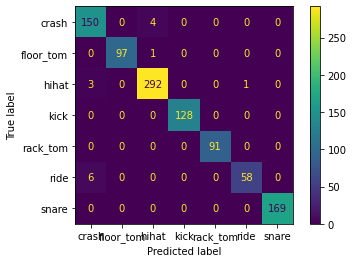

In [71]:
# Create confusion matrix
cm = confusion_matrix(y_test, results)

# display confusion matrix with ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
cm_display.plot();

# Plot

### Trimming

In [ ]:
# ipython display audio method - used on last cymbal sound in library
ipd.Audio(df['file_name'].iloc[-1])

In [ ]:
y, sr = librosa.load(df['file_name'].iloc[-1])
# print(f'y: {y[:10]}')
# print(f'shape y: {y.shape}')
# print(f'sr: {sr}')

#--output--
#y: [-1.5206266e-05 -1.3785218e-05 -8.1884637e-06  1.2335660e-06
 #-1.5576163e-05 -1.8971021e-05  1.1400133e-05 -7.5695393e-06
 #-2.3335941e-05 -1.7152441e-05]
#shape y: (20558,)
#sr: 22050

In [ ]:
pd.Series(y).plot(lw=0.5, 
                  title='Raw Audio File');

trim low end db off and provide index?..

In [ ]:
y_trimmed, ind = librosa.effects.trim(y, top_db=25)

pd.Series(y_trimmed).plot(lw=0.5, 
                          title='Trimmed Audio File');

In [ ]:
ipd.Audio(y_trimmed, rate=22050)

In [ ]:
y_zoomed = y[1500:2000]

pd.Series(y_zoomed).plot(lw=1, 
                  title='Zoomed Audio File');

## Spectogram

stft (Short-time Fourier transform)

    Signature:
    librosa.stft(
        y,
        *,
        n_fft=2048,
        hop_length=None,
        win_length=None,
        window='hann',
        center=True,
        dtype=None,
        pad_mode='constant',
    )

In [ ]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

In [ ]:
# plot transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title("Spectogram of Audio File", fontsize=18)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [ ]:
# plot transformed TRIMMED audio data

D = librosa.stft(y_trimmed)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape


fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title("Spectogram of TRIMMED Audio File", fontsize=18)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

## Mel Spectogram

In [ ]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

S_db_mel = librosa.amplitude_to_db(np.abs(S), ref=np.max)

In [ ]:
# plot transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title("Mel Spectogram of Audio File", fontsize=18)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [ ]:
S_db_mel